In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

**import library**

In [47]:
import numpy as np 
from numpy.random import seed
import pandas as pd 
from matplotlib import pyplot as plt
# DNN
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, RepeatVector, TimeDistributed
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import metrics
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder


**讀取檔案**

In [48]:
train_data = pd.read_csv('train.csv', index_col=0)
test_data = pd.read_csv('test.csv', index_col=0)
data_oil = pd.read_csv('oil.csv')
samp_subm = pd.read_csv('sample_submission.csv')
data_holi = pd.read_csv('holidays_events.csv')
data_store =  pd.read_csv('stores.csv')
data_trans = pd.read_csv('transactions.csv')
## holiday 重複的部分做處理
#  type：{'holiday':3,'transfer':4,'addition:'0','bridge':1,'work day':5,'event':2} nan=6
#  local:{'local':0,'region':1,'nation':2} nan=3
data_holi = data_holi[['date','type','locale']]
data_holi['locale'].replace({'Local':1,'Regional':2,'National':3},inplace=True)
data_holi['type'].replace({'Holiday':6,'Transfer':5,'Additional':4,'Bridge':3,'Event':2,'Work Day':1},inplace=True)
data_holi[['type','locale']]=data_holi[['type','locale']].astype(int)
data_holi = data_holi.groupby(['date'],as_index=False).agg({'type':'mean','locale':'first'})

all_data = pd.concat([train_data,test_data],ignore_index=True)
all_data['date'] =  pd.to_datetime(all_data['date'])
data_holi['date'] = pd.to_datetime(data_holi['date'])
data_oil['date'] = pd.to_datetime(data_oil['date'])

df_train1 = all_data.merge(data_holi, on = 'date', how='left')
df_train1 = df_train1.merge(data_oil, on = 'date', how='left')
df_train1 = df_train1.merge(data_store, on = 'store_nbr', how='left')
df_train1 = df_train1.rename(columns = {"type_x" : "holiday_type", "type_y" : "store_type"})
df_train1['day_of_week'] = df_train1['date'].dt.day_name()
df['day_of_week'].replace({'Monday':1,'Tuesday':2,'Wednesday':3,'Thursday':4,'Friday':5,'Saturday':6,'Sunday':7},inplace=True)
df['day_of_week'] = df['day_of_week'].astype(int)
train_columns = ['date','store_nbr','family','sales','day_of_week']
df = df_train1[train_columns]

C:\Users\User\AppData\Roaming\Python\Python37\site-packages\numpy\lib\arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [49]:
df_copy=df.copy()

In [50]:
start_date = '2017-04-01'
end_date = '2017-08-15'
train_index = len(train_data)
object_cols = [cname for cname in df.columns if df[cname].dtype == "object"]
number_cols = [cname for cname in df.columns if df[cname].dtype!="object" and cname!='date' and cname!='sales']
# buf[col] = ordinal_encoder.fit_transform(buf[col])
print(object_cols,number_cols)

['family', 'day_of_week'] ['store_nbr']


In [51]:
ordinal_encoder = OrdinalEncoder()
df[object_cols] = ordinal_encoder.fit_transform(df[object_cols])




C:\ProgramData\Anaconda3\envs\ProjectPy37\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\ProgramData\Anaconda3\envs\ProjectPy37\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


In [55]:
train = df[:train_index]
train_x_all = list(train.set_index('date').loc[start_date:end_date].groupby(['family'],as_index=True))

In [57]:
group = [31,30,27,26,23,19,18,16,15,10,6,1]
history_input = 10
train_input = []
train_output = []
for i in range(len(train_x_all)): #6912
    scaler = MinMaxScaler(feature_range=(0,1))
    family_num,train_x = train_x_all[i][0],train_x_all[i][1]


    for col in number_cols+object_cols:
        train_x[col] = scaler.fit_transform(train_x[col].values.reshape(-1,1))

    store = list(train_x.groupby(['store_nbr'],as_index=False))
    for s in range(len(store)):
        table = store[s][1]
        table_x = table.groupby(['date']).agg({"sales":"max","store_nbr":"mean","family":"mean","day_of_week":"mean"})
        table_y = table_x[['sales']]
        
        table_x.drop(columns=['sales'],inplace=True)

        for j in range(len(table_x)-history_input+1):
            train_input.append(table_x[j:j+history_input].values)
            train_output.append(table_y.iloc[j+history_input-1])
train_input=np.array(train_input)
train_output=np.array(train_output)



In [58]:
train_f_map = []
train_f_map.append([train_input,train_output])

In [63]:
from tensorflow.keras.layers import LSTM,RNN, Dense, Dropout, RepeatVector, TimeDistributed,GRU,Embedding

In [64]:
def Multi_Step_LSTM_model():
    
    # Use Keras sequential model
    model = Sequential()    
    

    model.add(GRU(4, input_shape=train_input[0].shape))
    model.add(Dense(1))
    
    # The output layer with linear activation to predict Open stock price
    model.add(Dense(units=1, activation = "linear"))
    
    return model

In [65]:
for i in range(len(train_f_map)):
    print(f"Model {i} training")
    train_input = train_f_map[i][0]
    train_output = train_f_map[i][1]

    model = Multi_Step_LSTM_model()
    model.compile(optimizer='adam', loss='mean_squared_error')#, metrics = ['accuracy'])
    # early_stop = EarlyStopping(monitor='val_loss',patience=2,verbose=1)
    history = model.fit(train_input,train_output,batch_size=1, epochs=1)#,callbacks=early_stop)
    train_f_map[i].append(model)
    train_f_map[i].append(history)
    # break


Model 0 training
228096/228096 [==============================] - 406s 2ms/step - loss: 1812833.2841


In [68]:
filepath = "model6/"

In [73]:
print(history.history['loss'])

[1776208.625]


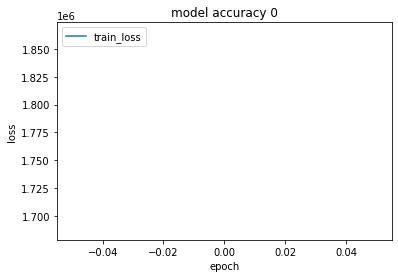

model_f0Saved model to disk


In [70]:
def draw(history,num):
    # val_acc = np.mean(history.history['val_accuracy'])
    # print("\n%s: %.2f%%" % ('val_acc', val_acc*100))
    # plt.plot(history.history['accuracy'])
    # plt.plot(history.history['val_accuracy'])
    plt.plot(history.history['loss'])
    # plt.plot(history.history['val_loss'])
    plt.title('model accuracy '+str(num))
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    # plt.legend(['train_acc', 'validation_acc','train_loss','val_loss'], loc='upper left')
    plt.legend(['train_loss'], loc='upper left')

    # plt.legend(['train','loss'], loc='upper left')
    plt.show()
for i in range(len(train_f_map)):
    model = train_f_map[i][2]
    history = train_f_map[i][3]

    draw(history,i)
    # serialize model to JSON
    model_json = model.to_json()
    with open(filepath+"model_f"+str(i)+".json", "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights(filepath+"model_f"+str(i)+".json.h5")
    print("model_f"+str(i)+"Saved model to disk")
    # break

# Predict

In [82]:
test_x = df[train_index:].copy().drop(columns=['sales'])
test_x_all = list(test_x.groupby("family"))

In [124]:
table_list = []
for i in range(len(test_x_all)):
    f_num,table_test = int(test_x_all[i][0]),test_x_all[i][1]
    table_train = train_x_all[f_num][1]
    table = pd.concat([table_train,table_test])
    print(table)
    table_list.append(table)



                     store_nbr  family  sales  day_of_week       date
2017-04-01 00:00:00   0.000000     0.0    9.0     0.333333        NaT
2017-04-01 00:00:00   0.169811     0.0    4.0     0.333333        NaT
2017-04-01 00:00:00   0.188679     0.0   14.0     0.333333        NaT
2017-04-01 00:00:00   0.207547     0.0   22.0     0.333333        NaT
2017-04-01 00:00:00   0.226415     0.0   11.0     0.333333        NaT
...                        ...     ...    ...          ...        ...
3029235              54.000000     0.0    NaN     4.000000 2017-08-31
3029268               6.000000     0.0    NaN     4.000000 2017-08-31
3029301               7.000000     0.0    NaN     4.000000 2017-08-31
3029334               8.000000     0.0    NaN     4.000000 2017-08-31
3029367               9.000000     0.0    NaN     4.000000 2017-08-31

[8262 rows x 5 columns]
                     store_nbr  family  sales  day_of_week       date
2017-04-01 00:00:00   0.000000     0.0    0.0     0.333333       

In [86]:
import datetime

In [122]:
test_input = []
for i in range(len(test_x)):
    # print(test_x.iloc[i])
    end_day = test_x.iloc[i].date
    f_num,store_nbr = int(test_x['family'].iloc[i]),test_x['store_nbr'].iloc[i]
    table = table_list[f_num]
    store = list(table.groupby('store_nbr',as_index=False))
    index = [s for s in range(len(store)) if store[s][0]==store_nbr][0]
    store = store[index][1]
    # test_d = store[store['date']==end_day]
    print(store.index)
    # test_input.append(test_d)
    break
print(test_input)




DatetimeIndex(['2017-04-01', '2017-04-02', '2017-04-03', '2017-04-04',
               '2017-04-05', '2017-04-06', '2017-04-07', '2017-04-08',
               '2017-04-09', '2017-04-10',
               ...
               '2017-08-06', '2017-08-07', '2017-08-08', '2017-08-09',
               '2017-08-10', '2017-08-11', '2017-08-12', '2017-08-13',
               '2017-08-14', '2017-08-15'],
              dtype='datetime64[ns]', name='date', length=274, freq=None)
[]
